In [47]:
using Gadfly, Colors, ImageView, Images, ExcelReaders, DataArrays, DataFrames

# Settings

# path = "/home/rock/Documents"  # Linux PC
# path = "C://Documents/Meetup/juliaActuarial"  # Windows laptop
path = "H://shared"  # Windows PC

In [46]:
Pkg.build("ImageMagick")

INFO: Building ImageMagick
INFO: Installing ImageMagick library


## Section 1: Understanding Present Value

## Section 2: Life Tables

### 2.1 Transition intensity (Baseline Hazard Function based on Gompertz-Makeham mortality)


## $$ \mu_x = \alpha\,e^{\beta x} + \lambda $$

## $$ _tq_x = 1 - exp(- \int_{s=0}^t \mu_{x+s}\,ds) $$

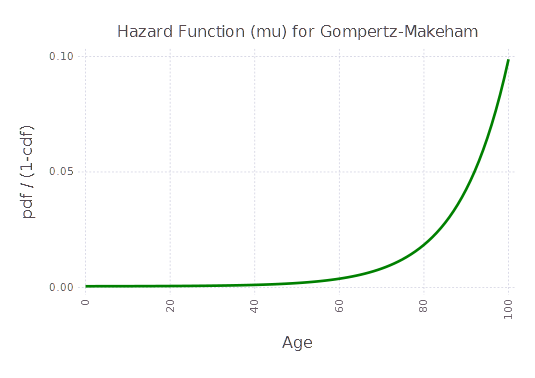

In [51]:
using Gadfly, Colors

function hazardF_GM(a, b, l)
    age = 0:100
    pdf = (a * exp(b*age) + l) .* exp(-l*age - (a/b)*(exp(b*age) - 1))
    cdf = 1 - exp(-l*age - (a/b)*(exp(b*age) - 1))
    hf = pdf ./ (1 - cdf)
    
    p = plot(
    x = age,
    y = hf,
    Stat.xticks(ticks=[0, 20, 40, 60, 80, 100]),
    Theme(minor_label_font_size=8pt, major_label_font_size=12pt, line_width=2pt, default_color=colorant"green"),
    Geom.line,
    Guide.ylabel("pdf / (1-cdf)"),
    Guide.xlabel("Age"),
    Guide.xticks(orientation=:vertical),
    Guide.title("Hazard Function (mu) for Gompertz-Makeham")
    )
end

hazardF_GM(2e-5, 0.085, 5e-4)

### 2.2 Life table

#### 2.2.1 Display life table spreadsheet

In [5]:
using ImageView, Images

# ltImage = imread("/home/rock/Documents/lifetable.png")
# ltImage = imread("C://Documents/Meetup/juliaActuarial/lifetable.png")
ltImage = imread("$path/pics/lifetable.png")
view(ltImage, pixelspacing = [1,1])

(ImageCanvas,ImageSlice2d: zoom = Graphics.BoundingBox(0.0,767.0,0.0,435.0))

#### 2.2.2 Read an Excel table into Julia

In [84]:
using ExcelReaders
using DataArrays, DataFrames

# fileList = filter!(r"\.xlsx$", readdir("/home/rock/Documents/lifeTables"))
# lifeTableColNames = [:age, :q, :l, :d, :L, :T, :e]
lifeTableColNames = [:age, :q, :l, :d]
# path = "/home/rock/Documents/lifeTables"
# path = "C://Documents/Meetup/juliaActuarial"
lt01 = readxl(DataFrame, "$path/lifetables/Table01.xlsx", "Table 1!A8:D108", 
header=false, colnames=lifeTableColNames);
head(lt01)

,age,q,l,d
1,0-1,0.006122943013906479,100000.0,612.2943115234375
2,1-2,0.0004283820453565568,99387.703125,42.57590866088867
3,2-3,0.000274977704975754,99345.125,27.31769371032715
4,3-4,0.0002105848689097911,99317.8046875,20.914827346801758
5,4-5,0.00015775953943375498,99296.890625,15.665031433105469
6,5-6,0.00014510845358017832,99281.2265625,14.406545639038086


In [85]:
# Convert the :age column from string to integer
lt01[:age] = map(x -> parse(Int, match(r"^(\d+)", x).match), lt01[:age])
showcols(lt01)

101x4 DataFrames.DataFrame
| Col # | Name | Eltype  | Missing |
|-------|------|---------|---------|
| 1     | age  | Any     | 0       |
| 2     | q    | Float64 | 0       |
| 3     | l    | Float64 | 0       |
| 4     | d    | Float64 | 0       |

#### 2.2.3 Survivorship Function (l)

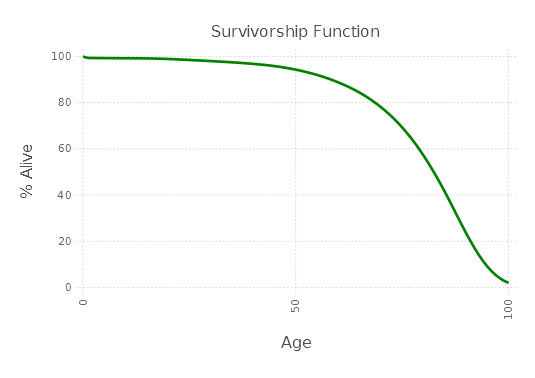

In [86]:
using Gadfly, Colors

function plotSurv(lt, color="green")
    """Plots the Survivorship Function for a lifetable"""
    c = parse(Colorant, color)
    
    p = plot(
    x = lt[:age],
    y = lt[:l] / 1000,
    Stat.yticks(ticks=[0, 20, 40, 60, 80, 100]),
    # Theme(default_point_size=2pt, minor_label_font_size=6pt, default_color=colorant"blue"),
    Theme(minor_label_font_size=8pt, major_label_font_size=12pt, line_width=2pt, default_color=c),
    Geom.line,
    Guide.ylabel("% Alive"),
    Guide.xlabel("Age"),
    Guide.xticks(orientation=:vertical),
    Guide.title("Survivorship Function")
    )
end

plotSurv(lt01)

#### 2.2.4 Conditional Probability of Dying in the Next Year (q)(log scale)

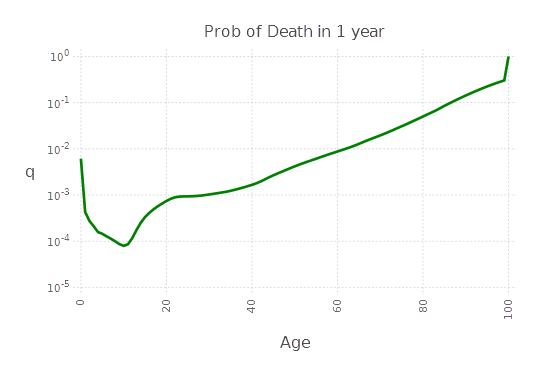

In [87]:
using Gadfly, Colors

function plotq(lt, color="green")
    """Plots the q Function for a lifetable"""
    c = parse(Colorant, color)
    
    p = plot(
    x = lt[:age],
    y = lt[:q],
    Stat.xticks(ticks=[0, 20, 40, 60, 80, 100]),
    # major_label_font="HelveticaBold",
    Theme(minor_label_font_size=8pt, major_label_font_size=12pt, line_width=2pt, default_color=c),
    Geom.line,
    Scale.y_log10,
    Guide.ylabel("q"),
    Guide.xlabel("Age"),
    Guide.xticks(orientation=:vertical),
    Guide.title("Prob of Death in 1 year")
    )
end

plotq(lt01)

### 2.3 Adjusting a Life Table for Time-dependent Risk Factors

In [88]:
function ltadjust(lt, rf)
    nrows = size(lt, 1)
    ltadj = DataFrame(age = lt[:age], q = zeros(Float64,nrows), l = zeros(Float64,nrows), d = zeros(Float64,nrows));
    ltadj[:q] = lt[:q] .* rf
    ltadj[1,:l] = 100000
    ltadj[1,:d] = ltadj[1, :q] * ltadj[1,:l]
    for i = 2:nrows
        ltadj[i,:l] = ltadj[i-1,:l] - ltadj[i-1,:d]
        ltadj[i,:d] = ltadj[i,:l] * ltadj[i, :q]
    end
    ltadj
end
0

0

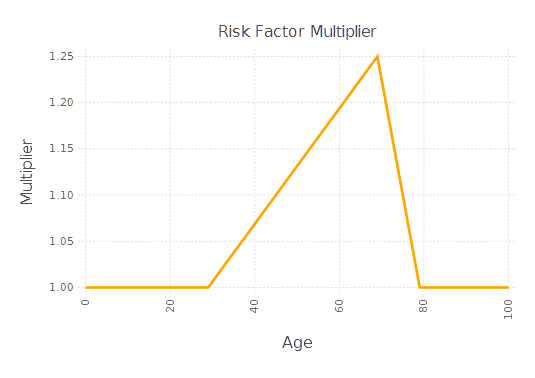

In [89]:
# Create a risk factor multiplier for condition 'a'
rfa = ones(Float64, 101)
rfa[31:70] = 1 + (0.25/40) * (1:40)
rfa[71:80] = 1.25 - (0.25/10) * (1:10)

plot(
x = 0:100,
y = rfa,
Stat.xticks(ticks=[0, 20, 40, 60, 80, 100]),
Theme(minor_label_font_size=8pt, major_label_font_size=12pt, line_width=2pt, default_color=colorant"orange"),
Geom.line,
Guide.ylabel("Multiplier"),
Guide.xlabel("Age"),
Guide.xticks(orientation=:vertical),
Guide.title("Risk Factor Multiplier")
)

## Section 3: One Policy Analysis, Term Life

### 3.1 Creating Policy Objects in Julia (Composite Types)

In [90]:
type TermPolicy
    startAge::Int
    duration::Int
    premium::Float64
    claim::Float64
end

type WholePolicy
    startAge::Int
    premium::Float64
    claim::Float64
end
0

0

In [91]:
tlp4030 = TermPolicy(40, 30, 7500, 300000)
intRate = (0.05, 0.04)
# np = 1  # Number of Policies
# r = 0.05  # Interest rate
# rsd = 0.04  # Standard Deviation of interest rate

(0.05,0.04)

### 3.2 Expected Reserves for ONE Term Life Policy

In [92]:
function make_tlpdf(tlpolicy, lifetable, intRate)
    """Returns a dataframe for a Term Life Policy and a lifetable of type DataFrame"""
    premium = tlpolicy.premium  # Premium
    claim = tlpolicy.claim  # Claim
    sa = tlpolicy.startAge
    dur = tlpolicy.duration
    r = intRate[1]
    TLP = DataFrame(year = 0:dur, discount = zeros(Float64,dur+1), probC = zeros(Float64,dur+1), 
    PVClaim = zeros(Float64,dur+1), probP = zeros(Float64,dur+1), PVPremium = zeros(Float64,dur+1),
    EPVFutureC = zeros(Float64,dur+1), EPVFutureP = zeros(Float64,dur+1), expRes = zeros(Float64,dur+1));  # DF for Term-Life Policy
    TLP[:discount] = 1 ./ ((1+r) .^ TLP[:year]);
    TLP[1:dur-1, :probC] = lifetable[sa+1:sa+dur-1, :d] / lifetable[sa+1, :l]
    TLP[dur, :probC] = 1 - (lifetable[sa+dur-1, :l] / lifetable[sa+1, :l])  # Claim is also paid if alive at end
    TLP[2:dur+1, :PVClaim] = claim .* TLP[2:dur+1, :discount] .* TLP[1:dur, :probC]
    TLP[1:dur, :probP] = lifetable[sa+1:sa+dur, :l] / lifetable[sa+1, :l]
    TLP[1:dur, :PVPremium] = premium .* TLP[1:dur, :discount] .* TLP[1:dur, :probP]
    TLP[1:dur, :EPVFutureC] = map(x -> sum(TLP[(x+2):end, :PVClaim]) / TLP[(x+1), :discount], TLP[1:end-1, :year])
    TLP[1:dur, :EPVFutureP] = map(x -> sum(TLP[(x+2):end, :PVPremium]) / TLP[(x+1), :discount], TLP[1:end-1, :year])
    TLP[:expRes] = TLP[:EPVFutureC] - TLP[:EPVFutureP]
    TLP
end

tlpDF = make_tlpdf(tlp4030, lt01, intRate)
head(tlpDF)
# head(tlpDF[:EPVFutureC])
# tail(tlpDF[:expRes])

,year,discount,probC,PVClaim,probP,PVPremium,EPVFutureC,EPVFutureP,expRes
1,0,1.0,0.0016634138872197836,0.0,1.0,7500.0,33475.061579138215,108502.80807977557,-75027.74650063735
2,1,0.9523809523809523,0.0017896432605433081,475.2611106342238,0.9983365892654722,7130.975637610515,34649.79049192919,106440.42406427333,-71790.63357234414
3,2,0.9070294784580498,0.001955694601602637,486.9777579709682,0.9965469497881593,6779.230950939858,35845.387038362656,104288.3431440758,-68442.95610571315
4,3,0.863837598531476,0.0021655696223347393,506.82075843281814,0.9945912920730529,6443.740149485279,37050.9480098,102043.3256107317,-64992.3776009317
5,4,0.822702474791882,0.0024047203832079454,534.4858462886733,0.9924257104704886,6123.533160383719,38253.82452358958,99702.29906273962,-61448.47453915004
6,5,0.7835261664684589,0.0026490793912409038,565.2484029850455,0.9900209883533,5817.80512295832,39445.099634806684,97262.25660322687,-57817.15696842018


### 3.3 Expected PV of Future Claims & Premiums

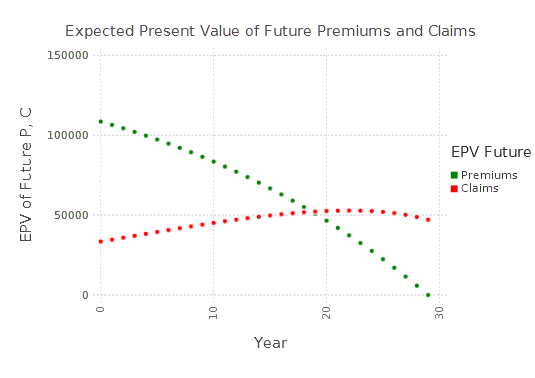

In [93]:
using Gadfly

plotEPVFuturePC = plot(
layer(
# first layer, Claims
x = tlpDF[1:end-1, :year],
y = tlpDF[1:end-1, :EPVFutureC],
Stat.yticks(ticks=[0, 50000, 100000, 150000]),
Theme(default_point_size=2pt, major_label_font_size=12pt, minor_label_font_size=8pt, default_color=colorant"red"),
Geom.point),
layer(
# second layer, Premiums
x = tlpDF[1:end-1, :year],
y = tlpDF[1:end-1, :EPVFutureP],
Stat.yticks(ticks=[0, 50000, 100000, 150000]),
Theme(default_point_size=2pt, major_label_font_size=12pt, minor_label_font_size=8pt, default_color=colorant"green"),
Geom.point),
Guide.ylabel("EPV of Future P, C"),
Guide.xlabel("Year"),
Guide.xticks(orientation=:vertical),
Guide.manual_color_key("EPV Future", ["Premiums", "Claims"], ["green", "red"]),
Guide.title("Expected Present Value of Future Premiums and Claims")
)

# draw(PNG("EPVFuturePCs.png", 12cm, 8cm), plotEPVFuturePC)

## Section 4: Modeling ONE Whole Life Policy

### 4.1 Expected Reserves

In [94]:
function make_wlpdf(WLPolicy, lifetable, intRate)
    """Returns a dataframe for a Whole Life Policy and a lifetable of type DataFrame"""
    premium = WLPolicy.premium  # Premium
    claim = WLPolicy.claim  # Claim
    sa = WLPolicy.startAge
    dur = 101 - sa
    r = intRate[1]
    WLP = DataFrame(year = 0:dur, discount = zeros(Float64,dur+1), probC = zeros(Float64,dur+1), 
    PVClaim = zeros(Float64,dur+1), probP = zeros(Float64,dur+1), PVPremium = zeros(Float64,dur+1),
    EPVFutureC = zeros(Float64,dur+1), EPVFutureP = zeros(Float64,dur+1), expRes = zeros(Float64,dur+1));  # DF for Term-Life Policy
    WLP[:discount] = 1 ./ ((1+r) .^ WLP[:year]);
    WLP[1:dur, :probC] = lifetable[sa+1:sa+dur, :d] / lifetable[sa+1, :l]
    WLP[2:dur+1, :PVClaim] = claim .* WLP[2:dur+1, :discount] .* WLP[1:dur, :probC]
    WLP[1:dur, :probP] = lifetable[sa+1:sa+dur, :l] / lifetable[sa+1, :l]
    WLP[1:dur, :PVPremium] = premium .* WLP[1:dur, :discount] .* WLP[1:dur, :probP]
    WLP[1:dur, :EPVFutureC] = map(x -> sum(WLP[(x+2):end, :PVClaim]) / WLP[(x+1), :discount], WLP[1:end-1, :year])
    WLP[1:dur, :EPVFutureP] = map(x -> sum(WLP[(x+2):end, :PVPremium]) / WLP[(x+1), :discount], WLP[1:end-1, :year])
    WLP[:expRes] = WLP[:EPVFutureC] - WLP[:EPVFutureP]
    WLP
end
0

0

### 4.2 Example - One Whole Life Policy

In [95]:
wlp40 = WholePolicy(40, 2500, 300000)
irWLP = (0.06, 0.075)  # Interest Rate Tuple of (mean, stdDev)
wlpDF = make_wlpdf(wlp40, lt01, irWLP)
wlpDF[end-6:end-1,:]

,year,discount,probC,PVClaim,probP,PVPremium,EPVFutureC,EPVFutureP,expRes
1,55,0.04056742205903171,0.0210531322928071,296.7921629425031,0.09387254892069986,9.520418279557832,23338.26489123825,475.4448912418841,22862.819999996365
2,56,0.03827115288587897,0.01770091652034813,241.71829341139687,0.07281941662789276,6.967207567066502,18422.621096870414,321.92304314666524,18100.69805372375
3,57,0.03610486121309337,0.014470081911477655,191.72674029351626,0.055118498846467835,4.97511437781442,14217.703406578199,203.44217861929556,14014.261227958903
4,58,0.03406118982367299,0.011482862117697003,147.86046202528118,0.04064841693499018,3.4613336131362606,10729.741037529595,114.02766699897786,10615.713370530617
5,59,0.03213319794686131,0.008832445669785124,110.69432442734185,0.029165553556216382,2.342956264129214,7928.666864472272,47.9554431283756,7880.711421343896
6,60,0.030314337685718208,0.020333107886431258,80.32492218738774,0.020333107886431258,1.540961746673543,5754.653175405073,0.0,5754.653175405073


## Section 5: Simulation Analysis for MANY Policies

### 5.1 Simulation with variable deaths, variable interest rates

In [96]:
function simWLP(WLPolicy, lifetable, intRate, nSim)
    """Returns Actual and Expected Reserves Dataframes"""
    premium = WLPolicy.premium 
    claim = WLPolicy.claim
    sa = WLPolicy.startAge
    dur = 101 - sa
    r = intRate[1]
    rsd = intRate[2]
    
    NPol = Array{Int64}(nSim, dur)
    MeanDeaths = Array{Float64}(nSim, dur)
    SdDeaths = Array{Float64}(nSim, dur)
    NDeaths = Array{Int64}(nSim, dur)
    srand(100)  # Seed for Random Number Generation
    NPol[:, 1] = np * ones(Int64, nSim)
    
    for yp = 0:dur-1  # yp is the year of the policy. At 'startAge', yp = 0
        MeanDeaths[:,(yp+1)] = lifetable[(sa+yp+1), :q] * NPol[:,(yp+1)]
        SdDeaths[:,(yp+1)] = sqrt(MeanDeaths[:,(yp+1)] * (1 - lifetable[(sa+yp+1), :q]))
        NDeaths[:,(yp+1)] = round(Int, max(0, MeanDeaths[:,(yp+1)] .+ randn(nSim) .* SdDeaths[:,(yp+1)]))
        if yp < dur-1
            NPol[:,(yp+2)] = NPol[:,(yp+1)] .- NDeaths[:,(yp+1)]
        end
    end
    
    # Calculate Expected Reserves
    ExpResArr = zeros(nSim, dur)
    wlpDF = make_wlpdf(WLPolicy, lifetable, intRate)  # Contains expRes column for ONE policy
    for i = 1:nSim
        ExpResArr[i,:] = NPol[i,:] .* (wlpDF[1:end-1, :expRes])'
    end
    
    # Calculate Actual Reserves
    PrArr = zeros(nSim, dur+1)
    ClArr = zeros(nSim, dur+1)
    ActualResArr = zeros(nSim, dur+1)
    
    PrArr[:, 1:(end-1)] = NPol[:, 1:end] * premium
    ClArr[:, 2:end] = NDeaths[:, 1:end] * claim
    IRArr = randn(nSim, dur) * rsd + r  # Interest Rate Array
    ActualResArr[:, 1] = copy(PrArr[:, 1])
    
    for yp = 1:dur  # start from yp = 1; yp = 0 has already been assigned
        ActualResArr[:, (yp+1)] = (ActualResArr[:, yp] .* (1 + IRArr[:, yp])) .+ PrArr[:, (yp+1)] .- ClArr[:, (yp+1)]
        #=
        if yp < dur
            skimRows = ActualResArr[:, (yp+1)] .> (1 + skim) .* ExpResArr[:, (yp+1)]
            ActualResArr[skimRows, (yp+1)] = (1 + skim) .* copy(ExpResArr[skimRows, (yp+1)])
        end
        =#
    end
    
    # Probability of Sufficiency
    ExcessResArr = ActualResArr[:,2:end-1] .- ExpResArr[:,2:end]
    probSufficiency =  sum(ActualResArr[:, end-1] .> 0) / nSim
    (ActualResArr, ExcessResArr, probSufficiency)
end

1

1

### 5.2 Actual Reserves, Probability of Sufficiency

In [97]:
function plotEndingAR(wlp, lt, ir, nSim)
    actualResArr, excessResArr, prSuff = simWLP(wlp, lt, ir, nSim)
    percentExcessArr = (excessResArr ./ (actualResArr[:,2:end-1] .- excessResArr)) * 100
    meanPercentExcess = mean(percentExcessArr, 1)
    
    plotActResEnd = plot(
    x = actualResArr[:, end],
    Theme(major_label_font_size=12pt, minor_label_font_size=8pt, default_color=colorant"blue"),
    Geom.histogram(bincount=10),
    Guide.ylabel("Count"),
    Guide.xlabel("Actual Reserves at End"),
    Guide.xticks(orientation=:vertical),
    Guide.title("Probability of Sufficiency = $prSuff")
)
end

#=
plotPercentExcess = plot(
x = 1:length(meanPercentExcess)-10,
y = meanPercentExcess[1:length(meanPercentExcess)-10],
Geom.point,
Guide.xlabel("Year of policy"),
Guide.ylabel("Percent Excess"),
Guide.title("Mean Percentage Excess")
)
=#
0

0

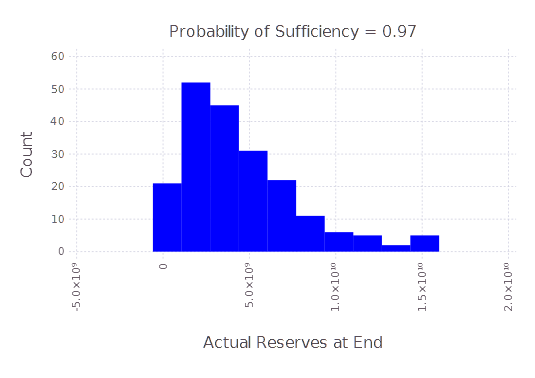

In [98]:
wlp40 = WholePolicy(40, 2500, 200000)
irWLP = (0.06, 0.075)  # Interest Rate Tuple of (mean, stdDev)
np = 10000  # Number of Policies
nSim = 200 # Number of Simulations

plotEndingAR(wlp40, lt01, irWLP, nSim)

### 5.3 Estimating Premium using Binary Search

In [99]:
function calcPremium(minProbSuff, policy, lifetable, irTup, nSim)
    """Returns the minimum premium that satisfies a probability of sufficiency"""
    # Using binary search
    claim = policy.claim
    sa = policy.startAge
    premHi = claim / (101-sa)
    premLo = 0
    while premHi - premLo > claim / 100000
        wlp = WholePolicy(sa, (premHi+premLo)/2, claim)
        actualResArr, excessResArr, ps = simWLP(wlp, lifetable, irTup, nSim)
        if ps > minProbSuff
            premHi = wlp.premium
        else
            premLo = wlp.premium
        end
    end
    (premHi + premLo) / 2
end
0

0

In [101]:
wlp40 = WholePolicy(40, 2500, 200000)
irWLP = (0.06, 0.075)  # Interest Rate Tuple of (mean, stdDev)
nSim = 200 # Number of Simulations
premium = calcPremium(0.8, wlp40, lt01, irWLP, nSim)
@printf("Estimated Premium = %6.2f", premium)

Estimated Premium = 2000.35

## Section 6: How Risk Factors affect Life Insurance Premiums

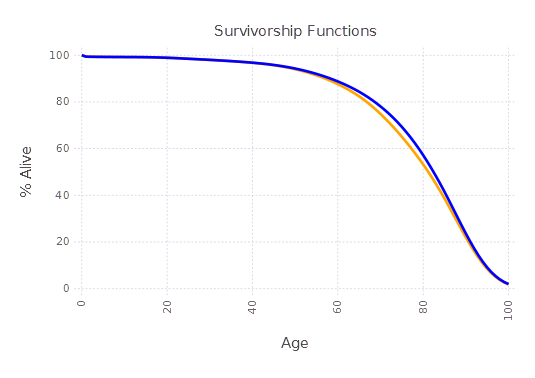

In [102]:
# Calculate the life table for risk factor 'a'
lta = ltadjust(lt01, rfa)

function plotCompareSurv(lt1, lt2)
    """Plots two Survivorship Functions"""  
    p = plot(
    layer(
    # 1st layer
    x = lt1[:age],
    y = lt1[:l] / 1000,
    Stat.yticks(ticks=[0, 20, 40, 60, 80, 100]),
    Stat.xticks(ticks=[0, 20, 40, 60, 80, 100]),
    Theme(minor_label_font_size=8pt, major_label_font_size=12pt, line_width=2pt, default_color=colorant"blue"),
    Geom.line),
    layer(
    # 2nd layer
    x = lt1[:age],
    y = lt2[:l] / 1000,
    Theme(minor_label_font_size=8pt, major_label_font_size=12pt, line_width=2pt, default_color=colorant"orange"),
    Geom.line),
    Guide.ylabel("% Alive"),
    Guide.xlabel("Age"),
    Guide.xticks(orientation=:vertical),
    Guide.title("Survivorship Functions")
    )
end

plotCompareSurv(lt01, lta)

In [103]:
# Calculate Premiums for Base case and Risk Case
probSuff = 0.8
prBase = calcPremium(probSuff, wlp40, lt01, irWLP, nSim)
prRisk = calcPremium(probSuff, wlp40, lta, irWLP, nSim)
#(prBase, prRisk)
@printf("Premium Base = %6.2f, Premium Risk = %6.2f", prBase, prRisk)

Premium Base = 2000.35, Premium Risk = 2130.03

## Section 7: Conclusion

### 7.1 Sources

#### Life Tables (All 18)
##### ftp://ftp.cdc.gov/pub/Health_Statistics/NCHS/Publications/NVSR/63_07/